# Kr analysis (run 3392)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import copy
import time
import glob
print("Running on ", time.asctime())

import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Tue Mar 28 16:34:48 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/run3392/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = os.environ["IC_DATA"] + "/Kr2016/data/3392/"

In [5]:
pattern = "$IC_DATA/pmaps_waves.gdcsnext.*_3392.root.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles))

# files: 75


### Define event class

In [6]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []
        self.S1t   = []

        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []
        self.S2t   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.T     = -1
        self.ok    = False

### Define dataset class

In [7]:
class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [8]:
#@timefunc
def fill_evts(s1s, s2s, sis, evts_out, times, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = 0
        evt.nS2 = 0

        s1time = 0
        for peak, (t, e) in s1.items():
            sel  = e > 0.5
            t, e = t[sel], e[sel]
            if t.size < 5:
                continue
            evt.nS1 += 1
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]
            evt.S1t.append(s1time)
        
        s2time = 0
        for peak, (t, e) in s2.items():
            w = width(t, to_mus=True)
            if w>20:
                continue
            evt.nS2 += 1
            evt.S2w.append(w)
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]
            evt.S2t.append(s2time)
            
            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.T  = times[i]
        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        with tb.open_file(ifile) as h5f:
            times = h5f.root.Run.events.cols.timestamp[:] * 1e-3
        fill_evts(pmapf.df_to_pmaps_dict(s1s),
                  pmapf.df_to_pmaps_dict(s2s),
                  pmapf.df_to_s2si_dict (sis),
                  evts_out, times - np.min(times), ifile)
    return Dataset(evts_out)


# Read data

In [9]:
full = build_dataset(ifiles)

/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.000_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.001_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.002_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.003_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.004_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.005_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.006_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.007_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.008_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.009_3392.root.h5 163
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3392/pmaps_waves.gdcsnext.010_3392.root.h5 163

## General plots about S1 and S2 (no selections applied)

In [10]:
data = full

#### Number of S1 and S2 signals

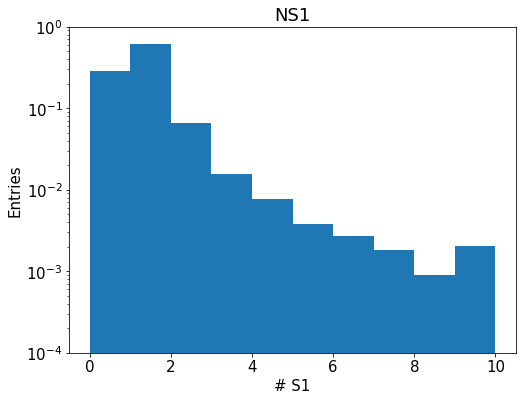

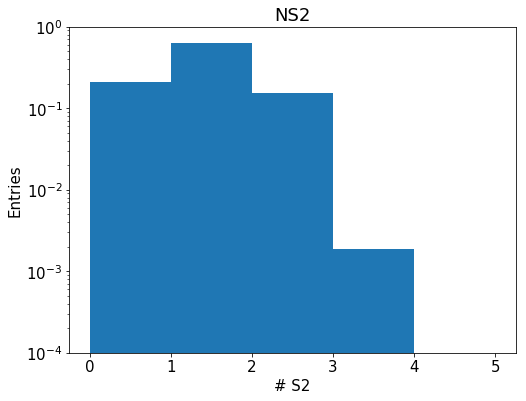

In [11]:
pdf(data.nS1, 10, range=(0, 10))
labels("# S1", "Entries")
save("NS1")

################################
pdf(data.nS2,  5, range=(0, 5))
labels("# S2", "Entries")
save("NS2")


<b>
1. With the current configuration, the probability of having more than one S2 if ~20%.

2. On the other hand, the ratio of events with exactly one S1 is ~60%
</b>

## From now on the study is focused on those events with exactly one S1 and one S2

In [12]:
oneS1oneS2 = full[full.ok]
data = oneS1oneS2
print("Full set   :", full.evts.size, "events")
print("Reduced set:", data.evts.size, "events")
print("Ratio      :", data.evts.size/full.evts.size)

Time spent in _create_attrs: 0.22557997703552246 s
Full set   : 12225 events
Reduced set: 5212 events
Ratio      : 0.4263394683026585


<b>
The ratio of "reliable" to total events is ~51.3%
</b>

# Distribution of events in Z

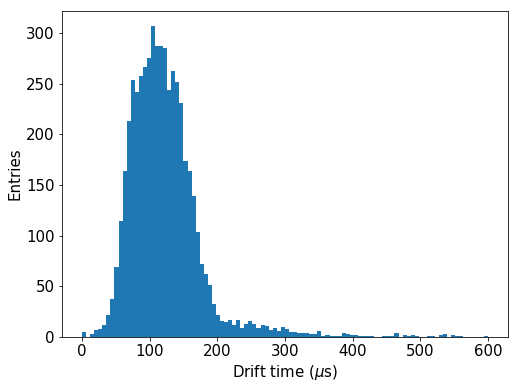

In [13]:
hist(flat(data.Z), 100, (0, 600))
labels("Drift time ($\mu$s)", "Entries")

<b>
Looks like there is an accumulation of events for Z < 200 $\mu$s and a flat distribution for Z > 200 $\mu$s.
</b>

# Comparison between Z < 250 and Z > 250

In [55]:
closeToAnode   = oneS1oneS2[flat(oneS1oneS2.Z < 250)]
closeToCathode = oneS1oneS2[flat(oneS1oneS2.Z > 250)]

z_anode     = flat(closeToAnode.Z)
z_cathode   = flat(closeToCathode.Z)

lbls = ["Anode", "Cathode"]

Time spent in _create_attrs: 0.19964599609375 s
Time spent in _create_attrs: 0.007253170013427734 s


# S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


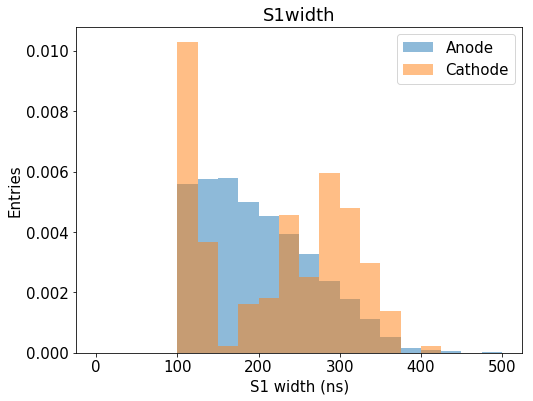

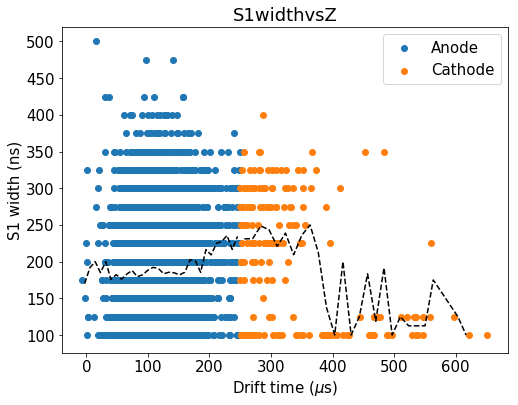

In [56]:
s1w_anode   = flat(closeToAnode.S1w)
s1w_cathode = flat(closeToCathode.S1w)

################################
doublehist(s1w_anode, s1w_cathode, lbls, 20, range=(0, 500))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
doublescatter(z_anode, s1w_anode, z_cathode, s1w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s1w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 width (ns)")
save("S1widthvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


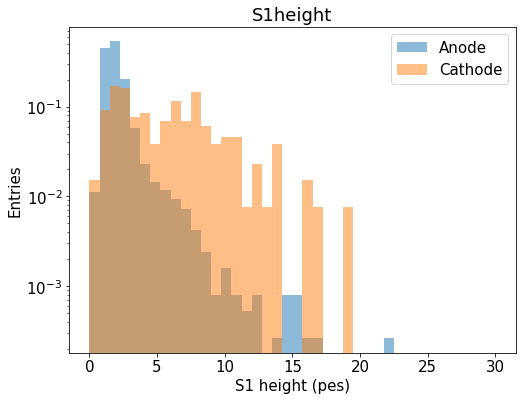

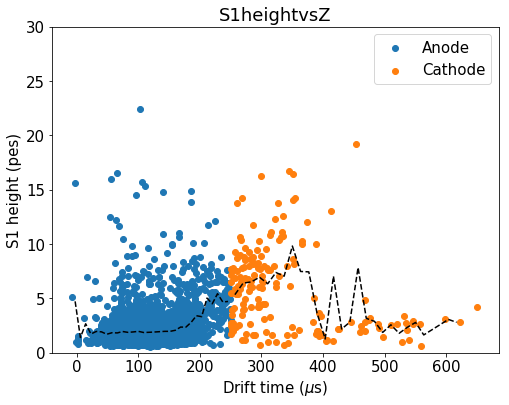

In [57]:
s1h_anode   = flat(closeToAnode.S1h)
s1h_cathode = flat(closeToCathode.S1h)

ylim = 0, 30
################################
doublehist(s1h_anode, s1h_cathode, lbls, 40, range=ylim, log=True)
labels("S1 height (pes)", "Entries")
save("S1height")

################################
doublescatter(z_anode, s1h_anode, z_cathode, s1h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


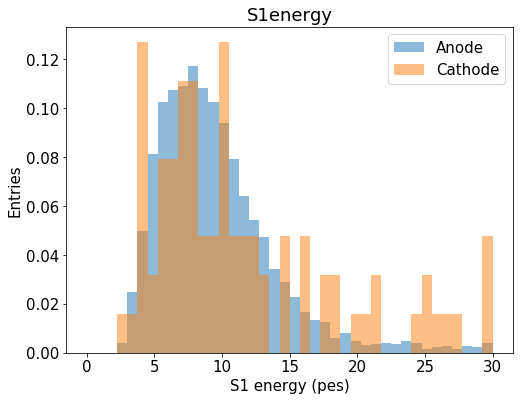

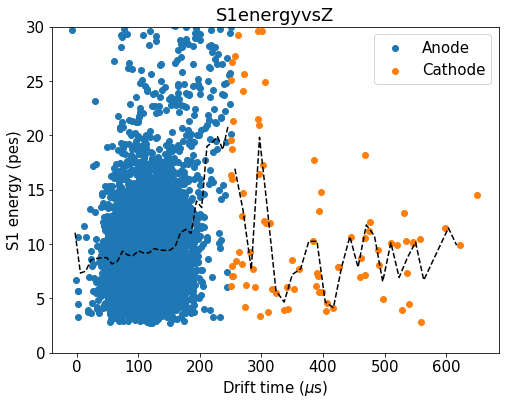

In [58]:
s1i_anode   = flat(closeToAnode.S1i)
s1i_cathode = flat(closeToCathode.S1i)

ylim = 0, 30
################################
doublehist(s1i_anode, s1i_cathode, lbls, 40, range=ylim)
labels("S1 energy (pes)", "Entries")
save("S1energy")

################################
doublescatter(z_anode, s1i_anode, z_cathode, s1i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

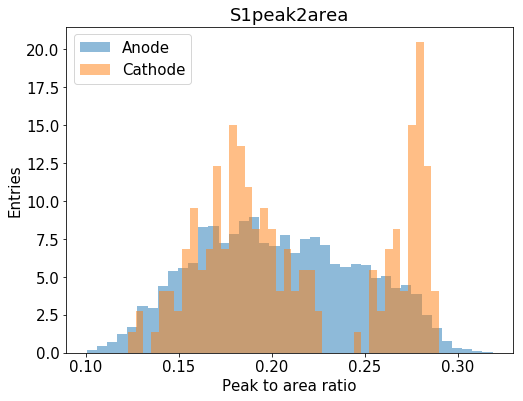

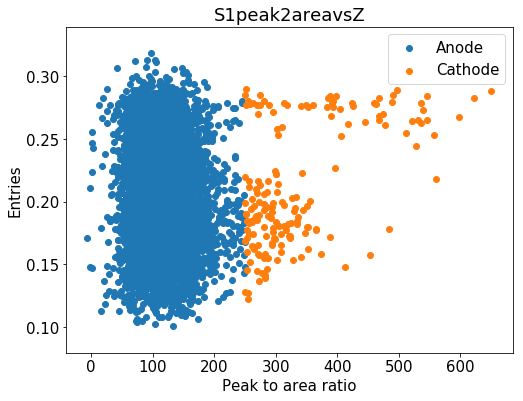

In [59]:
S1_ratio_anode   = s1h_anode/s1i_anode
S1_ratio_cathode = s1h_cathode/s1i_cathode

################################
doublehist(S1_ratio_anode, S1_ratio_cathode, lbls, 40)
labels("Peak to area ratio", "Entries")
save("S1peak2area")

doublescatter(z_anode, S1_ratio_anode, z_cathode, S1_ratio_cathode, lbls)
labels("Peak to area ratio", "Entries")
save("S1peak2areavsZ")

# S2

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


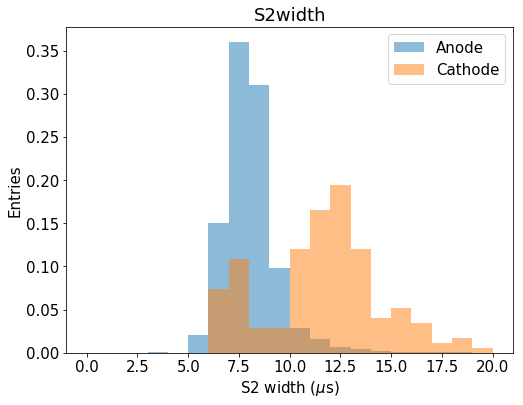

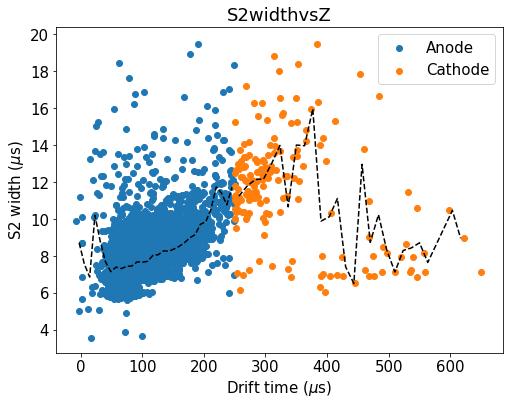

In [60]:
s2w_anode   = flat(closeToAnode.S2w)
s2w_cathode = flat(closeToCathode.S2w)

################################
doublehist(s2w_anode, s2w_cathode, lbls, 20, range=(0, 20))
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

################################
doublescatter(z_anode, s2w_anode, z_cathode, s2w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s2w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
save("S2widthvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


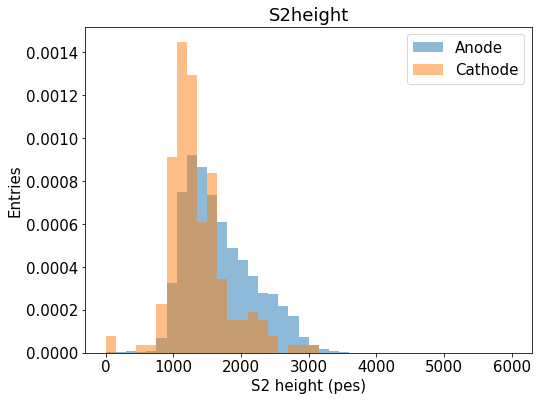

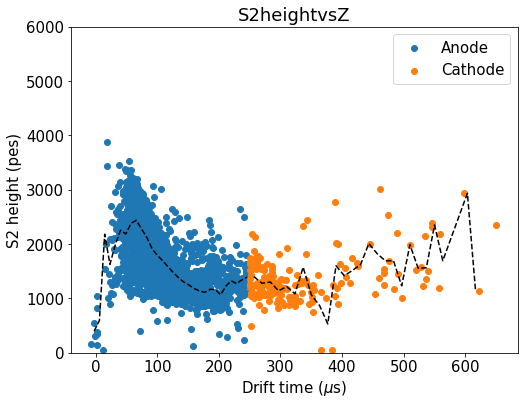

In [61]:
s2h_anode   = flat(closeToAnode.S2h)
s2h_cathode = flat(closeToCathode.S2h)

ylim = 0, 6e3
################################
doublehist(s2h_anode, s2h_cathode, lbls, 40, range=ylim)
labels("S2 height (pes)", "Entries")
save("S2height")

################################
doublescatter(z_anode, s2h_anode, z_cathode, s2h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


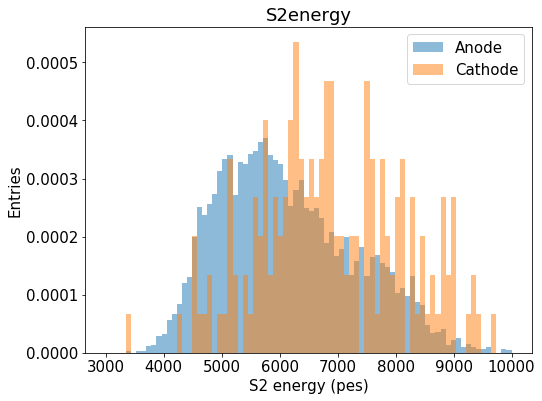

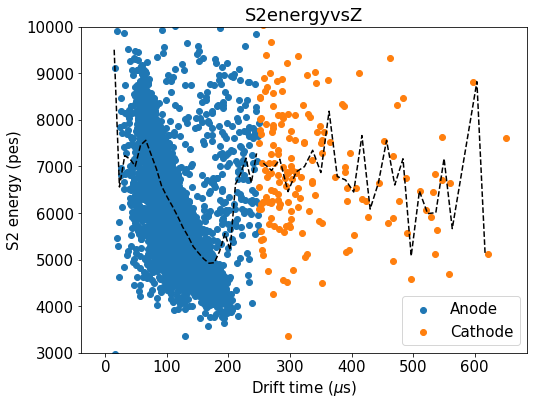

In [62]:
s2i_anode   = flat(closeToAnode.S2i)
s2i_cathode = flat(closeToCathode.S2i)

ylim = 3e3, 10e3
################################
doublehist(s2i_anode, s2i_cathode, lbls, 80, range=ylim)
labels("S2 energy (pes)", "Entries")
save("S2energy")

################################
doublescatter(z_anode, s2i_anode, z_cathode, s2i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

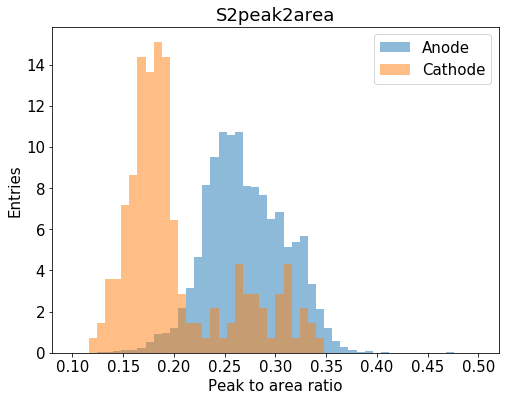

In [63]:
S2_ratio_anode   = s2h_anode/s2i_anode
S2_ratio_cathode = s2h_cathode/s2i_cathode

################################
doublehist(S2_ratio_anode, S2_ratio_cathode, lbls, 50, range=(0.1, 0.5))
labels("Peak to area ratio", "Entries")
save("S2peak2area")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


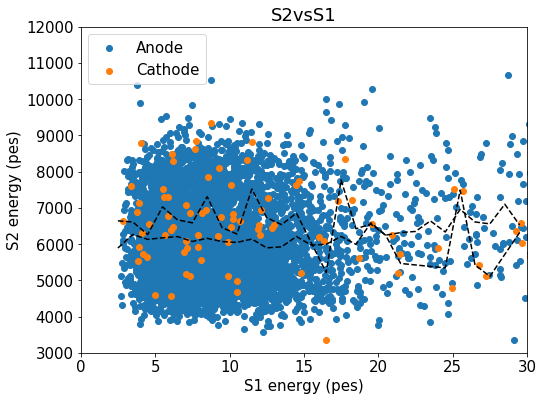

In [64]:
doublescatter(s1i_anode, s2i_anode, s1i_cathode, s2i_cathode, lbls)
xlim = 0, 30
ylim = 3e3, 12e3
plt.xlim(xlim)
plt.ylim(ylim)
x, y, _ = fitf.profileX(s1i_anode, s2i_anode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(s1i_cathode, s2i_cathode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

# Further selections: S1width < 160 ns

In [65]:
closeToAnodeShortS1   = closeToAnode[flat(closeToAnode.S1w < 160)]
closeToCathodeShortS1 = closeToCathode[flat(closeToCathode.S1w < 160)]

z_anode   = flat(closeToAnodeShortS1.Z)
z_cathode = flat(closeToCathodeShortS1.Z)

lbls = ["Anode", "Cathode"]

Time spent in _create_attrs: 0.13385486602783203 s
Time spent in _create_attrs: 0.0021729469299316406 s


# S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


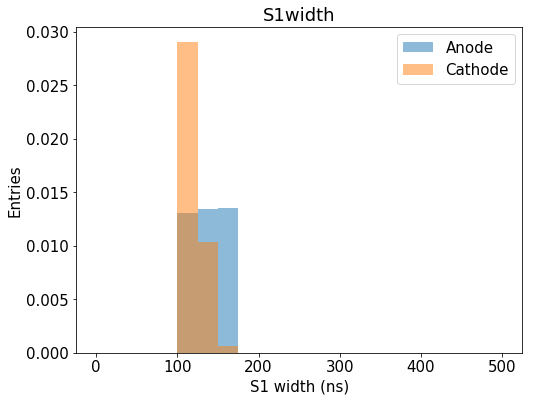

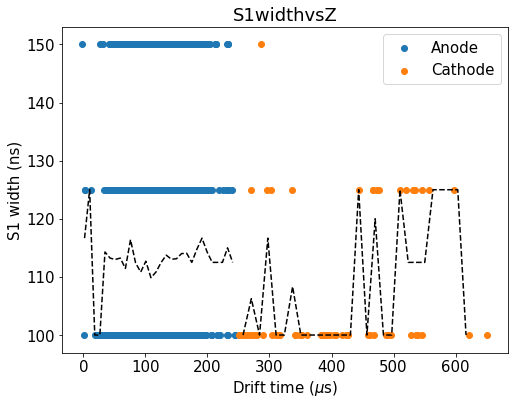

In [66]:
s1w_anode   = flat(closeToAnodeShortS1.S1w)
s1w_cathode = flat(closeToCathodeShortS1.S1w)

################################
doublehist(s1w_anode, s1w_cathode, lbls, 20, range=(0, 500))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
doublescatter(z_anode, s1w_anode, z_cathode, s1w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s1w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 width (ns)")
save("S1widthvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


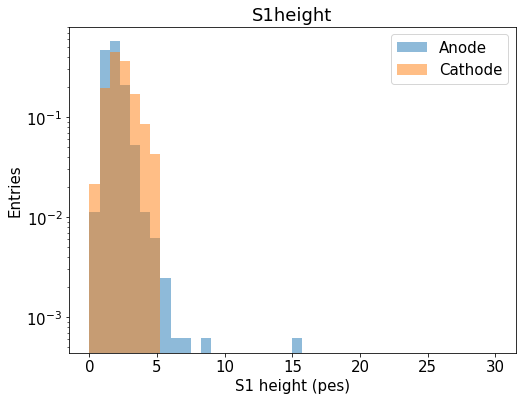

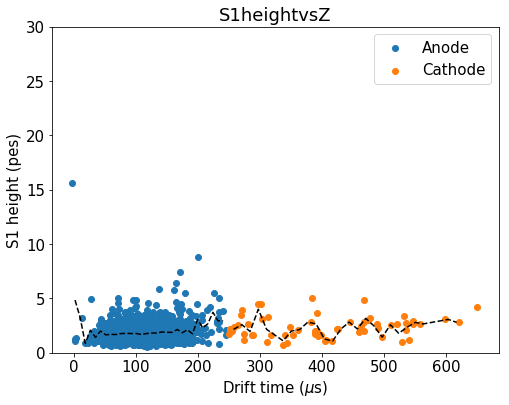

In [67]:
s1h_anode   = flat(closeToAnodeShortS1.S1h)
s1h_cathode = flat(closeToCathodeShortS1.S1h)

ylim = 0, 30
################################
doublehist(s1h_anode, s1h_cathode, lbls, 40, range=ylim, log=True)
labels("S1 height (pes)", "Entries")
save("S1height")

################################
doublescatter(z_anode, s1h_anode, z_cathode, s1h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


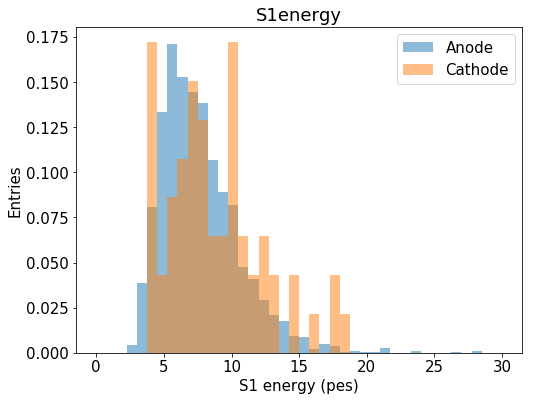

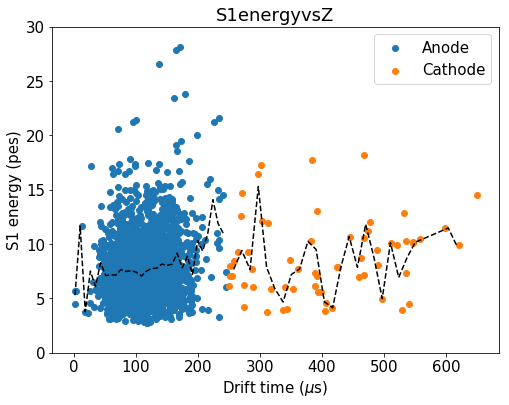

In [68]:
s1i_anode   = flat(closeToAnodeShortS1.S1i)
s1i_cathode = flat(closeToCathodeShortS1.S1i)

ylim = 0, 30
################################
doublehist(s1i_anode, s1i_cathode, lbls, 40, range=ylim)
labels("S1 energy (pes)", "Entries")
save("S1energy")

################################
doublescatter(z_anode, s1i_anode, z_cathode, s1i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

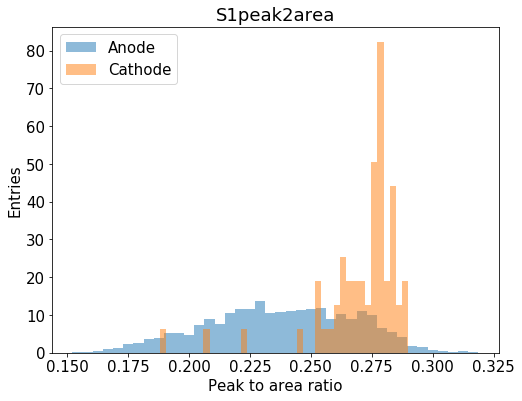

In [69]:
S1_ratio_anode   = s1h_anode/s1i_anode
S1_ratio_cathode = s1h_cathode/s1i_cathode

################################
doublehist(S1_ratio_anode, S1_ratio_cathode, lbls, 40)
labels("Peak to area ratio", "Entries")
save("S1peak2area")

# S2

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


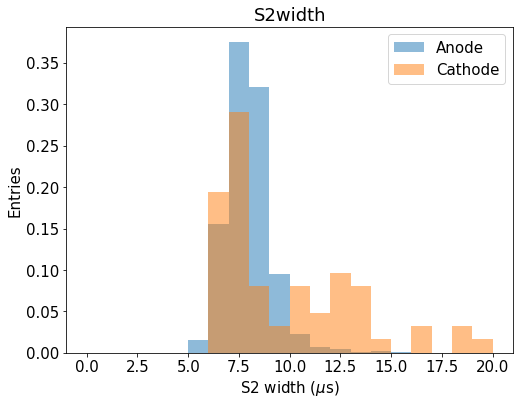

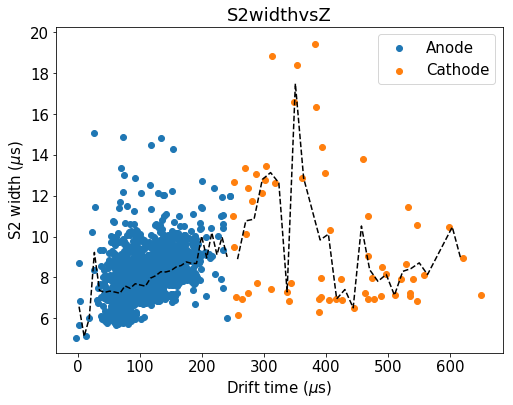

In [70]:
s2w_anode   = flat(closeToAnodeShortS1.S2w)
s2w_cathode = flat(closeToCathodeShortS1.S2w)

################################
doublehist(s2w_anode, s2w_cathode, lbls, 20, range=(0, 20))
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

################################
doublescatter(z_anode, s2w_anode, z_cathode, s2w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s2w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
save("S2widthvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


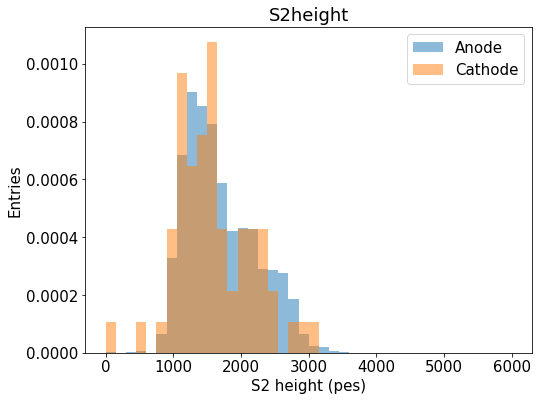

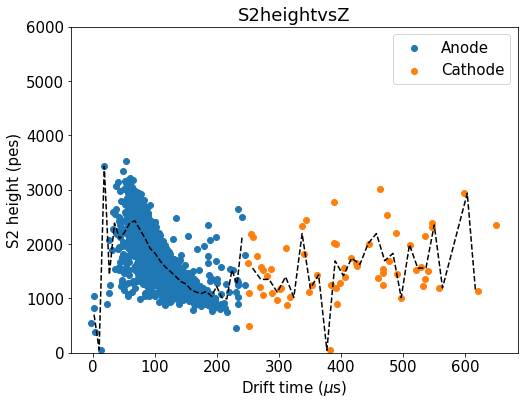

In [71]:
s2h_anode   = flat(closeToAnodeShortS1.S2h)
s2h_cathode = flat(closeToCathodeShortS1.S2h)

ylim = 0, 6e3
################################
doublehist(s2h_anode, s2h_cathode, lbls, 40, range=ylim)
labels("S2 height (pes)", "Entries")
save("S2height")

################################
doublescatter(z_anode, s2h_anode, z_cathode, s2h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


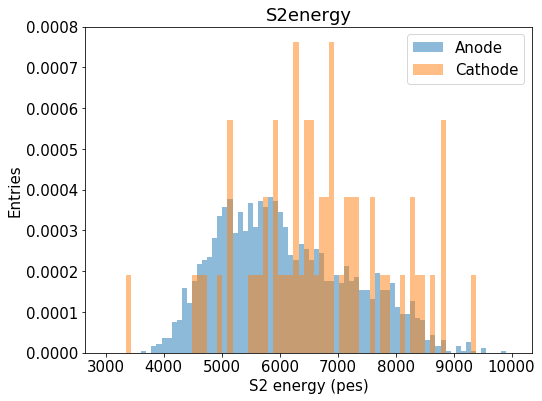

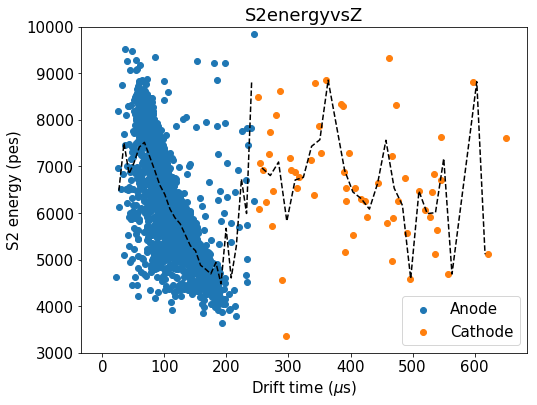

In [72]:
s2i_anode   = flat(closeToAnodeShortS1.S2i)
s2i_cathode = flat(closeToCathodeShortS1.S2i)

ylim = 3e3, 10e3
################################
doublehist(s2i_anode, s2i_cathode, lbls, 80, range=ylim)
labels("S2 energy (pes)", "Entries")
save("S2energy")

################################
doublescatter(z_anode, s2i_anode, z_cathode, s2i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

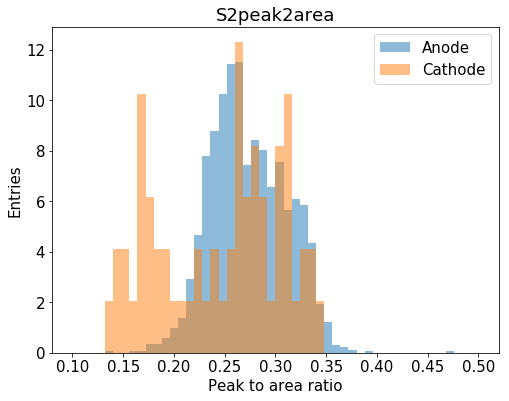

In [73]:
S2_ratio_anode   = s2h_anode/s2i_anode
S2_ratio_cathode = s2h_cathode/s2i_cathode

################################
doublehist(S2_ratio_anode, S2_ratio_cathode, lbls, 50, range=(0.1, 0.5))
labels("Peak to area ratio", "Entries")
save("S2peak2area")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


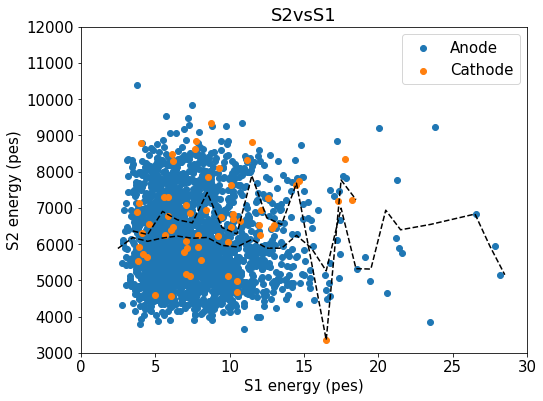

In [74]:
doublescatter(s1i_anode, s2i_anode, s1i_cathode, s2i_cathode, lbls)
xlim = 0, 30
ylim = 3e3, 12e3
plt.xlim(xlim)
plt.ylim(ylim)
x, y, _ = fitf.profileX(s1i_anode, s2i_anode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(s1i_cathode, s2i_cathode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

# Further selections: S1height < 5 pes

In [87]:
closeToAnodeShortTinyS1   = closeToAnodeShortS1[flat(closeToAnodeShortS1.S1h < 5)]
closeToCathodeShortTinyS1 = closeToCathodeShortS1[flat(closeToCathodeShortS1.S1h < 5)]

z_anode   = flat(closeToAnodeShortTinyS1.Z)
z_cathode = flat(closeToCathodeShortTinyS1.Z)

lbls = ["Anode", "Cathode"]

Time spent in _create_attrs: 0.15913605690002441 s
Time spent in _create_attrs: 0.0024869441986083984 s


# S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


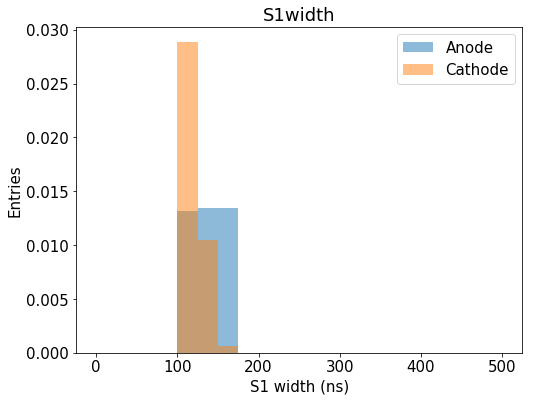

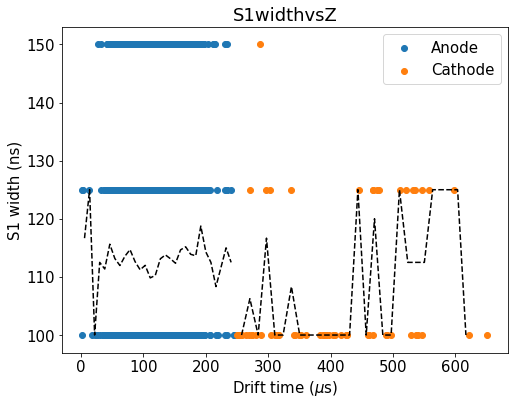

In [88]:
s1w_anode   = flat(closeToAnodeShortTinyS1.S1w)
s1w_cathode = flat(closeToCathodeShortTinyS1.S1w)

################################
doublehist(s1w_anode, s1w_cathode, lbls, 20, range=(0, 500))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
doublescatter(z_anode, s1w_anode, z_cathode, s1w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s1w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 width (ns)")
save("S1widthvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


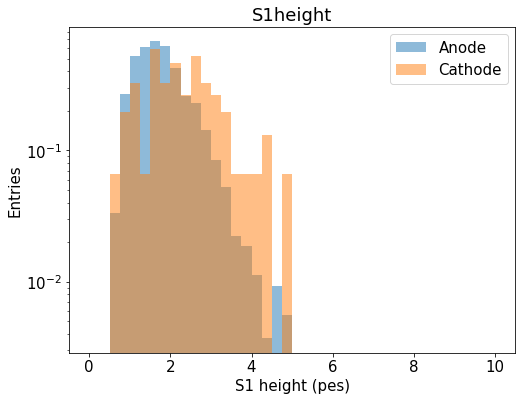

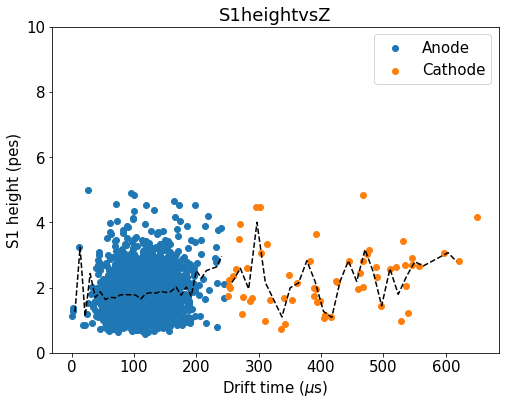

In [89]:
s1h_anode   = flat(closeToAnodeShortTinyS1.S1h)
s1h_cathode = flat(closeToCathodeShortTinyS1.S1h)

ylim = 0, 10
################################
doublehist(s1h_anode, s1h_cathode, lbls, 40, range=ylim, log=True)
labels("S1 height (pes)", "Entries")
save("S1height")

################################
doublescatter(z_anode, s1h_anode, z_cathode, s1h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


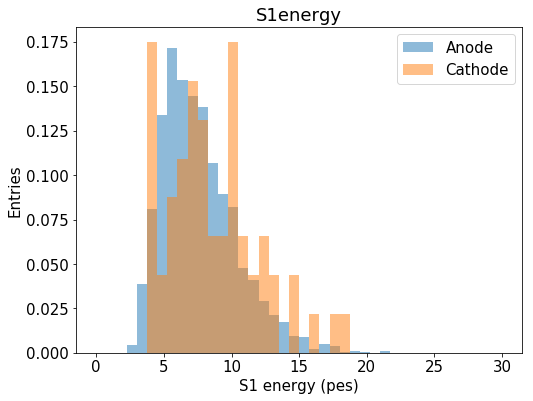

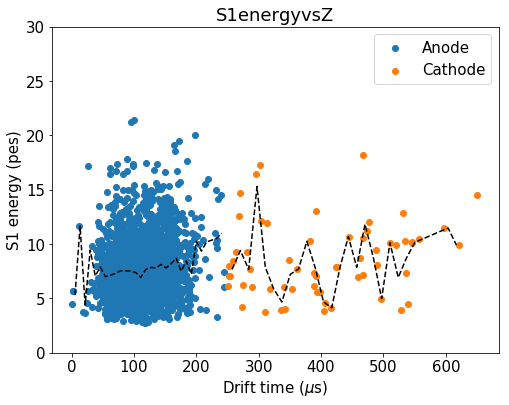

In [90]:
s1i_anode   = flat(closeToAnodeShortTinyS1.S1i)
s1i_cathode = flat(closeToCathodeShortTinyS1.S1i)

ylim = 0, 30
################################
doublehist(s1i_anode, s1i_cathode, lbls, 40, range=ylim)
labels("S1 energy (pes)", "Entries")
save("S1energy")

################################
doublescatter(z_anode, s1i_anode, z_cathode, s1i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

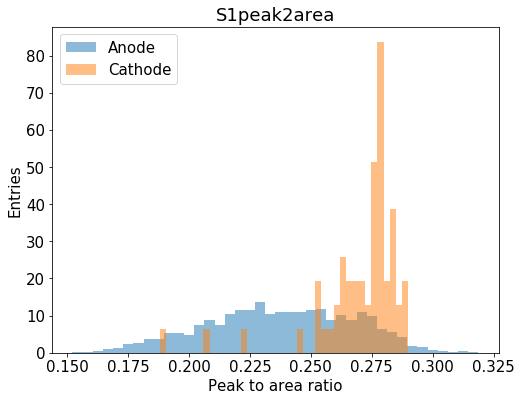

In [91]:
S1_ratio_anode   = s1h_anode/s1i_anode
S1_ratio_cathode = s1h_cathode/s1i_cathode

################################
doublehist(S1_ratio_anode, S1_ratio_cathode, lbls, 40)
labels("Peak to area ratio", "Entries")
save("S1peak2area")

# S2

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


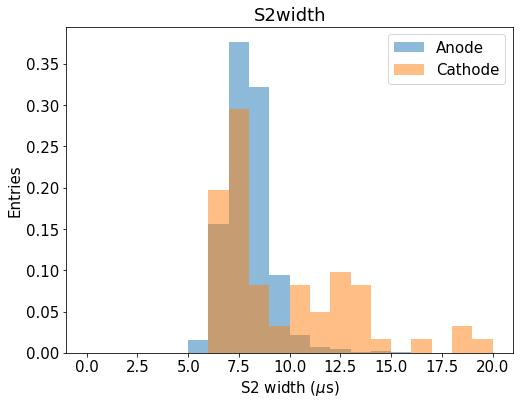

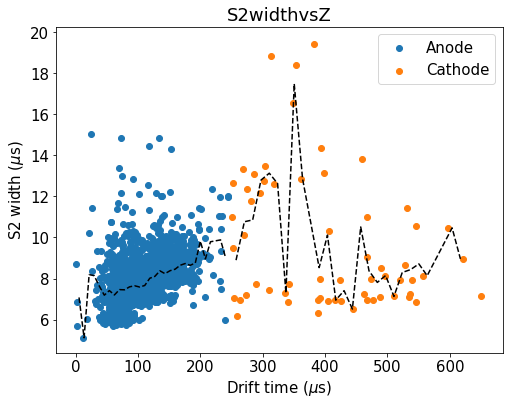

In [92]:
s2w_anode   = flat(closeToAnodeShortTinyS1.S2w)
s2w_cathode = flat(closeToCathodeShortTinyS1.S2w)

################################
doublehist(s2w_anode, s2w_cathode, lbls, 20, range=(0, 20))
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

################################
doublescatter(z_anode, s2w_anode, z_cathode, s2w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s2w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
save("S2widthvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


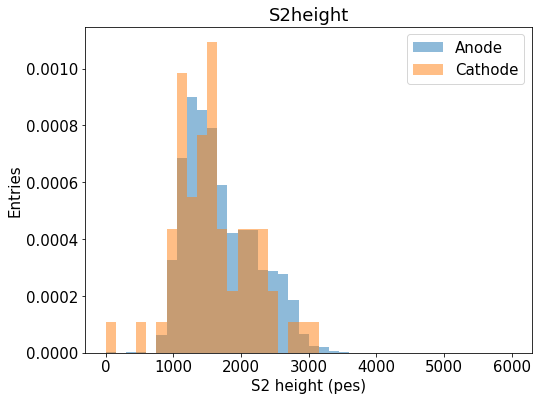

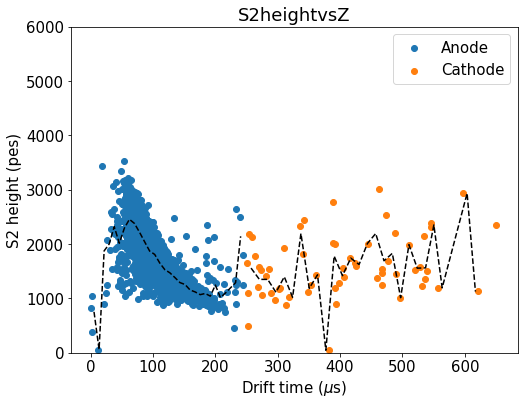

In [93]:
s2h_anode   = flat(closeToAnodeShortTinyS1.S2h)
s2h_cathode = flat(closeToCathodeShortTinyS1.S2h)

ylim = 0, 6e3
################################
doublehist(s2h_anode, s2h_cathode, lbls, 40, range=ylim)
labels("S2 height (pes)", "Entries")
save("S2height")

################################
doublescatter(z_anode, s2h_anode, z_cathode, s2h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


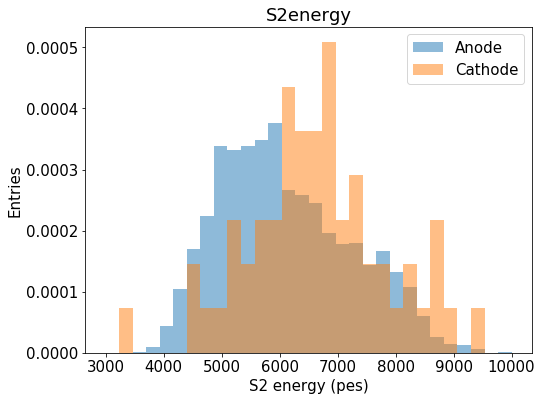

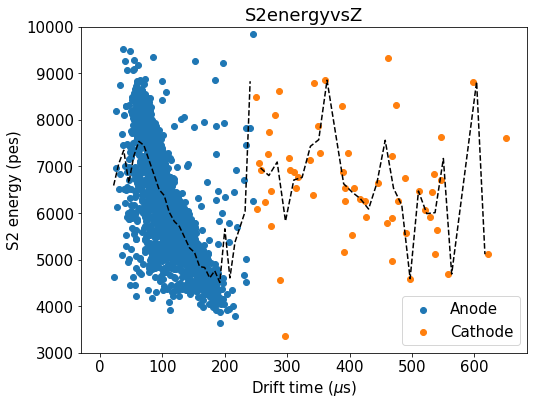

In [102]:
s2i_anode   = flat(closeToAnodeShortTinyS1.S2i)
s2i_cathode = flat(closeToCathodeShortTinyS1.S2i)

ylim = 3e3, 10e3
################################
doublehist(s2i_anode, s2i_cathode, lbls, 30, range=ylim)
labels("S2 energy (pes)", "Entries")
save("S2energy")

################################
doublescatter(z_anode, s2i_anode, z_cathode, s2i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

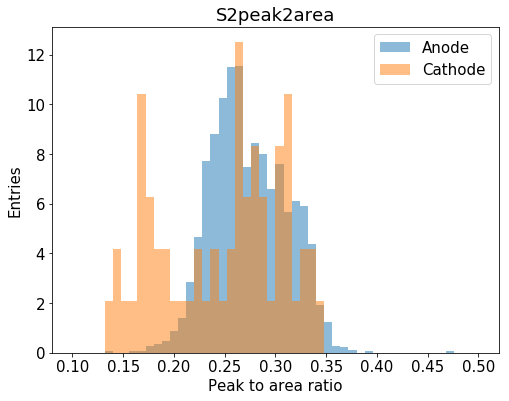

In [95]:
S2_ratio_anode   = s2h_anode/s2i_anode
S2_ratio_cathode = s2h_cathode/s2i_cathode

################################
doublehist(S2_ratio_anode, S2_ratio_cathode, lbls, 50, range=(0.1, 0.5))
labels("Peak to area ratio", "Entries")
save("S2peak2area")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


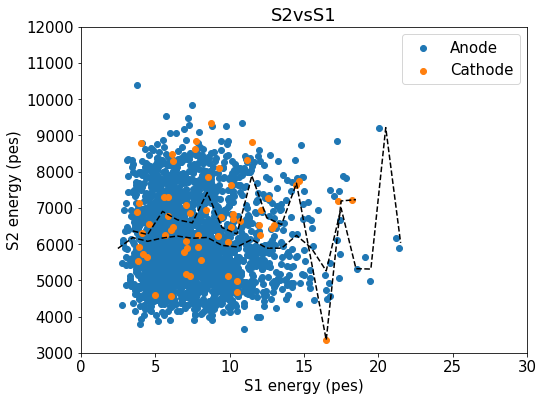

In [96]:
doublescatter(s1i_anode, s2i_anode, s1i_cathode, s2i_cathode, lbls)
xlim = 0, 30
ylim = 3e3, 12e3
plt.xlim(xlim)
plt.ylim(ylim)
x, y, _ = fitf.profileX(s1i_anode, s2i_anode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(s1i_cathode, s2i_cathode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

# Take small peak to area ratio in S1

In [85]:
#closeToAnodeShortTinyS1SmallP2A   = closeToAnodeShortTinyS1[(flat(closeToAnodeShortTinyS1.S1h)/flat(closeToAnodeShortTinyS1.S1i) > 0.25) & (flat(closeToAnodeShortTinyS1.S1h)/flat(closeToAnodeShortTinyS1.S1i) < 0.27)]
#closeToCathodeShortTinyS1SmallP2A = closeToCathodeShortTinyS1[(flat(closeToCathodeShortTinyS1.S1h)/flat(closeToCathodeShortTinyS1.S1i) > 0.25) & (flat(closeToCathodeShortTinyS1.S1h)/flat(closeToCathodeShortTinyS1.S1i) < 0.27)]

closeToAnodeShortTinyS1SmallP2A   = closeToAnodeShortTinyS1[flat(closeToAnodeShortTinyS1.S1h)/flat(closeToAnodeShortTinyS1.S1i) < 0.25]
closeToCathodeShortTinyS1SmallP2A = closeToCathodeShortTinyS1[flat(closeToCathodeShortTinyS1.S1h)/flat(closeToCathodeShortTinyS1.S1i) < 0.25]

z_anode   = flat(closeToAnodeShortTinyS1SmallP2A.Z)
z_cathode = flat(closeToCathodeShortTinyS1SmallP2A.Z)

lbls = ["Anode", "Cathode"]

Time spent in _create_attrs: 0.044682979583740234 s
Time spent in _create_attrs: 0.0002651214599609375 s


# S1

In [ ]:
s1w_anode   = flat(closeToAnodeShortTinyS1SmallP2A.S1w)
s1w_cathode = flat(closeToCathodeShortTinyS1SmallP2A.S1w)

################################
doublehist(s1w_anode, s1w_cathode, lbls, 20, range=(0, 500))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
doublescatter(z_anode, s1w_anode, z_cathode, s1w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s1w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 width (ns)")
save("S1widthvsZ")

In [ ]:
s1h_anode   = flat(closeToAnodeShortTinyS1SmallP2A.S1h)
s1h_cathode = flat(closeToCathodeShortTinyS1SmallP2A.S1h)

ylim = 0, 10
################################
doublehist(s1h_anode, s1h_cathode, lbls, 40, range=ylim, log=True)
labels("S1 height (pes)", "Entries")
save("S1height")

################################
doublescatter(z_anode, s1h_anode, z_cathode, s1h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

In [ ]:
s1i_anode   = flat(closeToAnodeShortTinyS1SmallP2A.S1i)
s1i_cathode = flat(closeToCathodeShortTinyS1SmallP2A.S1i)

ylim = 0, 30
################################
doublehist(s1i_anode, s1i_cathode, lbls, 40, range=ylim)
labels("S1 energy (pes)", "Entries")
save("S1energy")

################################
doublescatter(z_anode, s1i_anode, z_cathode, s1i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

In [ ]:
S1_ratio_anode   = s1h_anode/s1i_anode
S1_ratio_cathode = s1h_cathode/s1i_cathode

################################
doublehist(S1_ratio_anode, S1_ratio_cathode, lbls, 40)
labels("Peak to area ratio", "Entries")
save("S1peak2area")

# S2

In [ ]:
s2w_anode   = flat(closeToAnodeShortTinyS1SmallP2A.S2w)
s2w_cathode = flat(closeToCathodeShortTinyS1SmallP2A.S2w)

################################
doublehist(s2w_anode, s2w_cathode, lbls, 20, range=(0, 20))
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

################################
doublescatter(z_anode, s2w_anode, z_cathode, s2w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s2w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
save("S2widthvsZ")

In [ ]:
s2h_anode   = flat(closeToAnodeShortTinyS1SmallP2A.S2h)
s2h_cathode = flat(closeToCathodeShortTinyS1SmallP2A.S2h)

ylim = 0, 6e3
################################
doublehist(s2h_anode, s2h_cathode, lbls, 40, range=ylim)
labels("S2 height (pes)", "Entries")
save("S2height")

################################
doublescatter(z_anode, s2h_anode, z_cathode, s2h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

In [ ]:
s2i_anode   = flat(closeToAnodeShortTinyS1SmallP2A.S2i)
s2i_cathode = flat(closeToCathodeShortTinyS1SmallP2A.S2i)

ylim = 3e3, 10e3
################################
doublehist(s2i_anode, s2i_cathode, lbls, 40, range=ylim)
labels("S2 energy (pes)", "Entries")
save("S2energy")

################################
doublescatter(z_anode, s2i_anode, z_cathode, s2i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

In [ ]:
S2_ratio_anode   = s2h_anode/s2i_anode
S2_ratio_cathode = s2h_cathode/s2i_cathode

################################
doublehist(S2_ratio_anode, S2_ratio_cathode, lbls, 50, range=(0.1, 0.5))
labels("Peak to area ratio", "Entries")
save("S2peak2area")

In [ ]:
doublescatter(s1i_anode, s2i_anode, s1i_cathode, s2i_cathode, lbls)
xlim = 0, 30
ylim = 3e3, 12e3
plt.xlim(xlim)
plt.ylim(ylim)
x, y, _ = fitf.profileX(s1i_anode, s2i_anode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(s1i_cathode, s2i_cathode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

# Take low S1 energy (< 7 pes)

In [ ]:
closeToAnodeShortTinyS1SmallP2ALow   = closeToAnodeShortTinyS1SmallP2A[flat(closeToAnodeShortTinyS1SmallP2A.S1i) < 6]
closeToCathodeShortTinyS1SmallP2ALow = closeToCathodeShortTinyS1SmallP2A[flat(closeToCathodeShortTinyS1SmallP2A.S1i) < 6]

z_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.Z)
z_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.Z)

lbls = ["Anode", "Cathode"]

# S1

In [ ]:
s1w_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.S1w)
s1w_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.S1w)

################################
doublehist(s1w_anode, s1w_cathode, lbls, 20, range=(0, 500))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
doublescatter(z_anode, s1w_anode, z_cathode, s1w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s1w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 width (ns)")
save("S1widthvsZ")

In [ ]:
s1h_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.S1h)
s1h_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.S1h)

ylim = 0, 10
################################
doublehist(s1h_anode, s1h_cathode, lbls, 40, range=ylim, log=True)
labels("S1 height (pes)", "Entries")
save("S1height")

################################
doublescatter(z_anode, s1h_anode, z_cathode, s1h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

In [ ]:
s1i_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.S1i)
s1i_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.S1i)

ylim = 0, 30
################################
doublehist(s1i_anode, s1i_cathode, lbls, 40, range=ylim)
labels("S1 energy (pes)", "Entries")
save("S1energy")

################################
doublescatter(z_anode, s1i_anode, z_cathode, s1i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s1i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s1i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

In [ ]:
S1_ratio_anode   = s1h_anode/s1i_anode
S1_ratio_cathode = s1h_cathode/s1i_cathode

################################
doublehist(S1_ratio_anode, S1_ratio_cathode, lbls, 40)
labels("Peak to area ratio", "Entries")
save("S1peak2area")

# S2

In [ ]:
s2w_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.S2w)
s2w_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.S2w)

################################
doublehist(s2w_anode, s2w_cathode, lbls, 20, range=(0, 20))
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

################################
doublescatter(z_anode, s2w_anode, z_cathode, s2w_cathode, lbls)
x, y, _ = fitf.profileX(z_anode, s2w_anode, 30)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2w_cathode, 30)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
save("S2widthvsZ")

In [ ]:
s2h_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.S2h)
s2h_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.S2h)

ylim = 0, 6e3
################################
doublehist(s2h_anode, s2h_cathode, lbls, 40, range=ylim)
labels("S2 height (pes)", "Entries")
save("S2height")

################################
doublescatter(z_anode, s2h_anode, z_cathode, s2h_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2h_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2h_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

In [ ]:
s2i_anode   = flat(closeToAnodeShortTinyS1SmallP2ALow.S2i)
s2i_cathode = flat(closeToCathodeShortTinyS1SmallP2ALow.S2i)

ylim = 3e3, 10e3
################################
doublehist(s2i_anode, s2i_cathode, lbls, 50, range=ylim)
labels("S2 energy (pes)", "Entries")
save("S2energy")

################################
doublescatter(z_anode, s2i_anode, z_cathode, s2i_cathode, lbls)
plt.ylim(ylim)
x, y, _ = fitf.profileX(z_anode, s2i_anode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(z_cathode, s2i_cathode, 30, yrange=ylim)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

In [ ]:
S2_ratio_anode   = s2h_anode/s2i_anode
S2_ratio_cathode = s2h_cathode/s2i_cathode

################################
doublehist(S2_ratio_anode, S2_ratio_cathode, lbls, 50, range=(0.1, 0.5))
labels("Peak to area ratio", "Entries")
save("S2peak2area")

In [ ]:
doublescatter(s1i_anode, s2i_anode, s1i_cathode, s2i_cathode, lbls)
xlim = 0, 30
ylim = 3e3, 12e3
plt.xlim(xlim)
plt.ylim(ylim)
x, y, _ = fitf.profileX(s1i_anode, s2i_anode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
x, y, _ = fitf.profileX(s1i_cathode, s2i_cathode, 30, xrange=xlim, yrange=ylim)
plt.plot(x, y, profOpt)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")